In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('archive/stock_details_5_years.csv', index_col='Date', parse_dates=True)
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
Date,,,,,,,,
2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


<AxesSubplot:title={'center':'Star Bucks Stock Volume'}, xlabel='Date'>

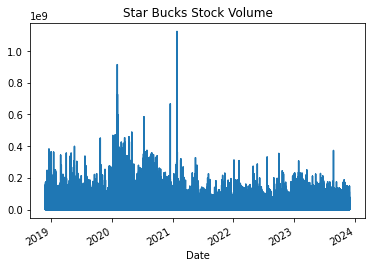

In [3]:

# plt.style.use('ggplot')
df['Volume'].plot(label='Close', title='Star Bucks Stock Volume')

In [4]:
X = df.iloc[:, :4]
y = df.iloc[:, 4:5] 
print(X)
# print(y)

                                 Open        High         Low       Close
Date                                                                     
2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508
2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131
2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000
2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497
2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853
...                               ...         ...         ...         ...
2023-11-29 00:00:00-05:00   26.360001   26.397499   26.120001   26.150000
2023-11-29 00:00:00-05:00   27.680000   28.535000   27.680000   28.350000
2023-11-29 00:00:00-05:00   75.940002   76.555000   75.257500   75.610001
2023-11-29 00:00:00-05:00   45.230000   45.259998   44.040001   44.209999
2023-11-29 00:00:00-05:00   84.629997   84.995003   83.529999   83.889999

[602962 rows x 4 columns]


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 
print(X_ss.shape)

(602962, 4)


In [6]:
#first 200 for training

X_train = X_ss[:200, :]
X_test = X_ss[200:400, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:400, :] 

In [7]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 4) (200, 1)
Testing Shape (200, 4) (200, 1)


In [8]:
print(X_train[0])
print(y_test[39])

[-0.34947141 -0.35121541 -0.35174132 -0.35215802]
[0.0023503]


In [9]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [10]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [11]:
print(X_train_tensors.shape)
print(X_train_tensors[199])
print(X_test_tensors[199])

print("===========")
print(y_train_tensors.shape)
print(y_train_tensors[5])

torch.Size([200, 4])
tensor([-0.0641, -0.0652, -0.0599, -0.0614])
tensor([-0.2491, -0.2512, -0.2492, -0.2524])
torch.Size([200, 1])
tensor([0.0216])


In [12]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 


In [13]:
print(X_train_tensors_final.shape)


torch.Size([200, 1, 4])


In [14]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        # print(x.shape)
        # print(x)
        # output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        # hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        # out = self.relu(hn)
        # out = self.fc_1(out) #first Dense
        # out = self.relu(out) #relu
        # out = self.fc(out) #Final Output
        # return out

In [15]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([200, 1, 4]) torch.Size([200, 1])
Testing Shape torch.Size([200, 1, 4]) torch.Size([200, 1])


In [16]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 4 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 


lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 
print(X_train_tensors_final.shape)

torch.Size([200, 1, 4])


In [17]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [26]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  print(y_train_tensors[0].shape)
  print(y_train_tensors[0])
  # optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # # obtain the loss function
  # loss = criterion(outputs, y_train_tensors)
 
  # loss.backward() #calculates the loss of the loss function
 
  # optimizer.step() #improve from loss, i.e backprop
  # if epoch % 100 == 0:
  #   print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size([1])
tensor([0.1488])
torch.Size

In [19]:
lstm = nn.LSTM(10, 5)
v1 = Variable(torch.randn(13,10))
v2 = Variable(torch.randn(4,13,10))
o1 = lstm(v1)
o2 = lstm(v2)
print(o1[0].size(), o2[0].size())
print(v2[0])

torch.Size([13, 5]) torch.Size([4, 13, 5])
tensor([[ 9.4468e-01, -6.3885e-01,  2.4538e-01, -4.0913e-01, -1.3162e+00,
         -1.6039e-01,  1.5538e+00, -4.9401e-02, -9.2170e-01,  2.1375e-01],
        [-9.9379e-01,  4.6913e-01, -2.1519e+00,  2.0213e-03,  7.0650e-02,
          5.2583e-01,  1.4677e-01, -1.7886e+00,  1.6453e+00, -1.0945e+00],
        [ 1.0983e+00, -1.4263e+00,  2.3660e-01,  7.8189e-01,  1.7239e+00,
         -3.7957e-01,  9.8787e-01, -1.0686e+00, -8.9470e-01,  5.2791e-01],
        [ 4.5168e-03,  2.7554e-01,  9.8531e-01, -1.9442e+00,  9.9710e-01,
         -5.3559e-01,  6.2812e-01, -1.2815e+00, -7.0339e-02, -1.5584e+00],
        [ 1.4493e+00,  2.4657e-01, -1.7151e+00,  3.6575e-01, -7.9226e-01,
         -7.0106e-01,  9.7184e-01,  1.6646e+00, -1.4480e+00, -3.0101e-01],
        [ 1.1773e+00,  1.0009e+00,  1.2819e-01, -5.4811e-01,  1.4819e+00,
         -1.3780e+00,  1.0503e+00, -2.3249e-01, -1.7041e-01,  8.9476e-01],
        [-2.6810e-01,  4.7784e-01,  1.1031e+00, -4.4480e-01,  4

In [20]:
N = 100 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)
print(y.shape)

(100, 1000)


In [21]:
X_train = np.random.rand(100, 10, 50)
print(X_train[0])
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
print(X_train_tensor[0])

[[2.43539719e-01 6.74792075e-01 6.63487935e-01 3.48673231e-01
  6.90214764e-01 8.81891020e-01 1.89875863e-02 8.30943554e-01
  5.04125331e-01 7.53499413e-01 7.38216285e-01 3.82448341e-01
  9.28662734e-02 8.59918676e-01 9.27490666e-01 9.74598759e-01
  6.77746421e-01 2.25487418e-01 6.03104991e-01 1.19738986e-01
  6.69741035e-01 4.10426267e-02 3.49929893e-02 6.38350564e-01
  2.26221281e-01 8.21772280e-01 1.83762687e-01 8.55725202e-01
  2.93962686e-01 4.41866661e-01 4.46712650e-01 5.57425778e-01
  2.74092862e-01 1.71974411e-01 8.51158714e-01 2.14745135e-01
  3.15951508e-01 9.05075369e-01 5.50284386e-01 7.34505949e-01
  7.49547629e-03 7.12785656e-01 8.12136361e-01 2.03621805e-01
  1.54813933e-01 2.59196021e-01 7.13545491e-01 1.00164920e-01
  1.84125638e-01 7.83571106e-01]
 [4.33582074e-01 7.56075106e-01 3.26793384e-02 8.97479253e-01
  5.19875194e-01 1.22318647e-01 3.24456384e-01 7.64482140e-01
  3.06572816e-01 4.41824899e-01 1.29603522e-01 9.44747503e-01
  9.01847240e-01 2.55205989e-01 5.580

In [22]:
import string
allowed_characters = string.ascii_letters + " .,;'"
n_letters = len(allowed_characters)
print(n_letters)

57


In [23]:
import torch

print(torch.cuda.is_available()) # True

torch.cuda.device_count() # 1


False


0

In [24]:
_tes = torch.tensor([1,2,3])
_tesRe = torch.reshape(_tes, (1,len(_tes)))
print(_tes.shape)
print(_tesRe)
print(_tesRe.shape)

torch.Size([3])
tensor([[1, 2, 3]])
torch.Size([1, 3])


In [33]:
al = 8
alt = torch.tensor(al)
print(alt.shape)
alt = alt.unsqueeze(0)
print(alt.shape)
print(alt)

torch.Size([])
torch.Size([1])
tensor([8])
